**References:**
* <a href="https://www.kaggle.com/code/gusthema/parkinson-s-disease-progression-prediction-w-tfdf" style="text-decoration:none">Parkinson's Disease Progression Prediction w TFDF</a>

# Import the Required Libraries

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("TensorFlow Version: ", tf.__version__)
print("TF-DF Version: ", tfdf.__version__)

TensorFlow Version:  2.11.0
TF-DF Version:  1.2.0


<br>

# Load the Dataset

In [3]:
data_dir =  "/kaggle/input/amp-parkinsons-disease-progression-prediction/"
data_dir

'/kaggle/input/amp-parkinsons-disease-progression-prediction/'

In [4]:
df_train_proteins = pd.read_csv(data_dir + "train_proteins.csv")
df_train_peptides = pd.read_csv(data_dir + "train_peptides.csv")
df_train_clinical = pd.read_csv(data_dir + "train_clinical_data.csv")

We will now examine each of these DataFrames in detail.

**UPDRS** is a rating instrument used to measure the severity and progression of Parkinson’s disease in patients. When a patient visits the clinic, the clinic will record how the patient scored on 4 parts of UPDRS test. This data can be found in `train_clinical`. The ratings for the the first 4 segments of UPDRS are available as ***updrs_1***, ***updrs_2***, ***updrs_3*** and ***updrs_4*** in `train_clinical`. Our goal is to train a model to predict these UPDRS ratings.

Let us examine the shape of train_clinical DataFrame.

In [5]:
df_train_clinical.shape

(2615, 8)

In [6]:
df_train_clinical.head(5)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


<br>

The clinic will also record the patient's **NPX**(Normalized Protein Expression) value for all the proteins relevant to Parkinson's disease during each visit. **NPX** is nothing but the value representing the protein concentration in shells. This data is available in the `train_proteins` DataFrame.

Let us examine the shape of train_proteins DataFrame.

In [7]:
df_train_proteins.shape

(232741, 5)

In [8]:
df_train_proteins.head(5)

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


<br>

Proteins are long molecules made up of multiple peptides. The clinic will record the **Peptide Abundance** of each peptide in proteins relevant to Parkinson's disease. It shows the peptide concentration, similar to NPX for proteins. This data can be found in the `train_peptides` DataFrame.

Let us examine the shape of the `train_peptides` DataFrame.

In [9]:
df_train_peptides.shape

(981834, 6)

In [10]:
df_train_peptides.head(5)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


<br>

# Plotting clinical data

We will pick a random `patient_id` and plot the target label values(`updrs_1`, `updrs_2`, `updrs_3`, `updrs_4`) of the patient against each month(`visit_month`).

In [11]:
df_train_clinical.patient_id.unique()

array([   55,   942,  1517,  1923,  2660,  3636,  3863,  4161,  4172,
        4923,  5027,  5036,  5178,  5645,  5742,  6054,  6211,  6420,
        7051,  7117,  7151,  7265,  7508,  7568,  7832,  7886,  8344,
        8699, 10053, 10138, 10174, 10541, 10715, 10718, 11459, 11686,
       11928, 12516, 12636, 12703, 12755, 12931, 13360, 13368, 13618,
       13804, 13852, 13968, 14035, 14124, 14242, 14270, 14344, 14450,
       14811, 15009, 15245, 15504, 15590, 16238, 16347, 16566, 16574,
       16778, 16931, 17154, 17201, 17414, 17727, 18183, 18204, 18553,
       18560, 19088, 20212, 20216, 20352, 20404, 20460, 20581, 20664,
       20707, 20791, 20792, 21126, 21537, 21729, 22126, 22623, 23175,
       23192, 23244, 23391, 23636, 24278, 24690, 24818, 24820, 24911,
       25562, 25739, 25750, 25827, 25911, 26005, 26104, 26210, 26809,
       27079, 27300, 27464, 27468, 27607, 27715, 27872, 27893, 27971,
       27987, 28327, 28342, 28818, 29313, 29417, 30119, 30155, 30416,
       30894, 30951,

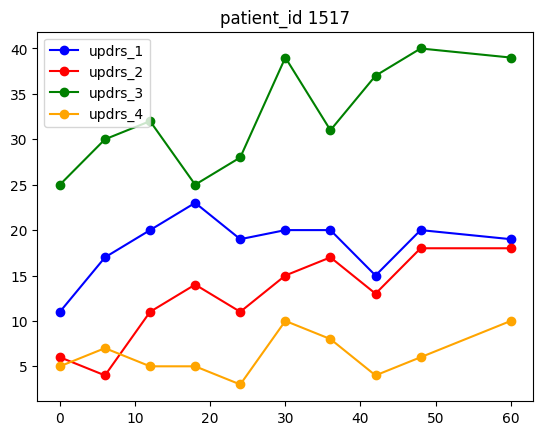

In [12]:
# Fetch data for patient with id 1517
plot_df = df_train_clinical[df_train_clinical["patient_id"]==1517]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="orange", label="updrs_4", linestyle="-")

ax.legend()
ax.set_title("patient_id 1517")
plt.show()

<br>

# Plotting protein data
We will pick a random `patient_id` and plot the first 40 Protein entries(`UniProt`) of the patient and their NPX value against patient's visit month(`visit_month`).

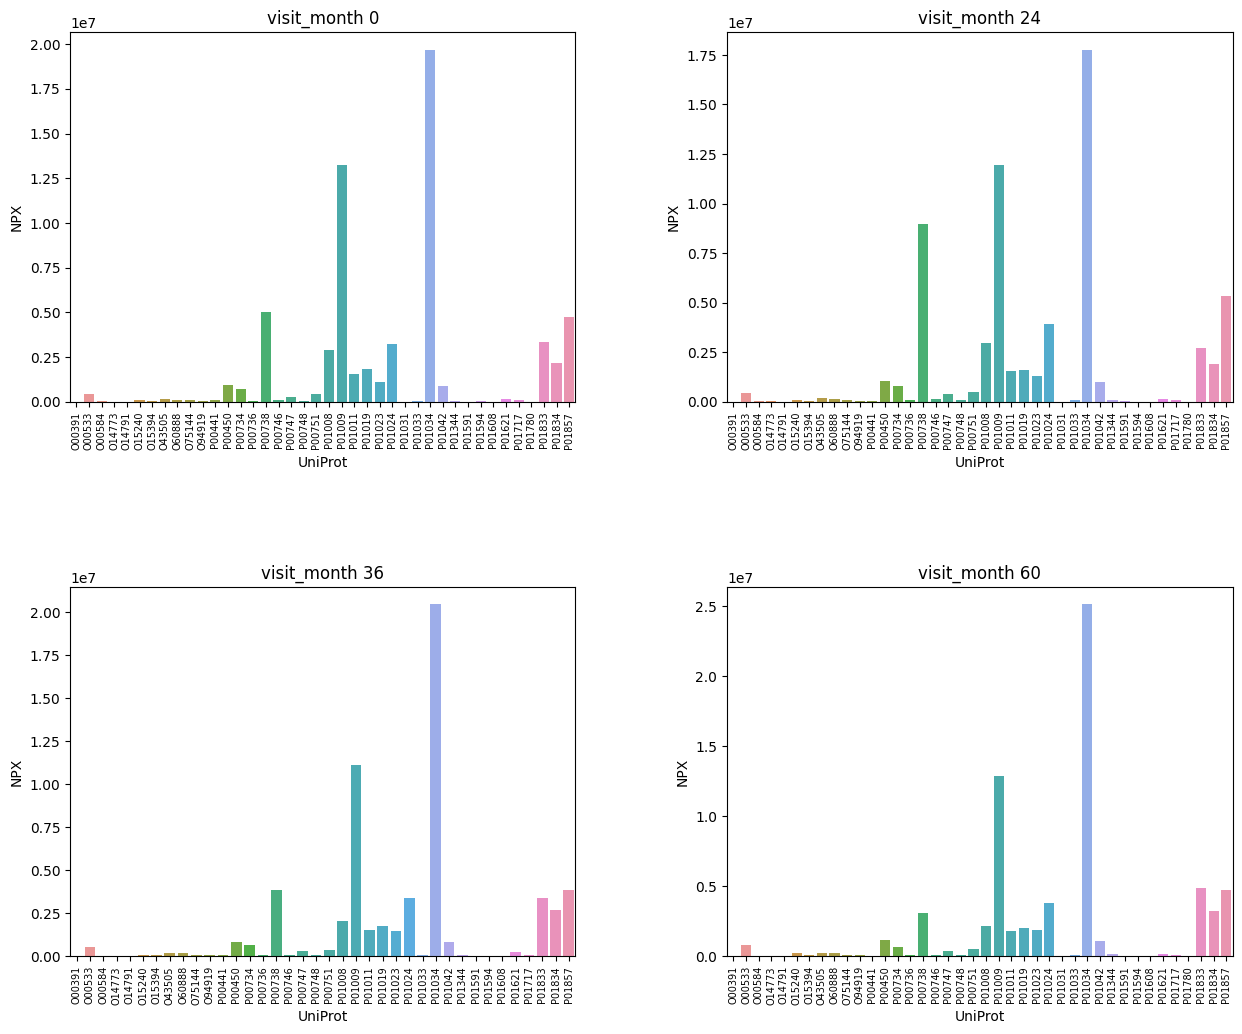

In [13]:
pro_plot_df = df_train_proteins[df_train_proteins["patient_id"]==1517]
protein_list = pro_plot_df['UniProt'].unique()
protein_list = protein_list[:40]
pro_plot_df = pro_plot_df[pro_plot_df['UniProt'].isin(protein_list)]
unique_month = pro_plot_df['visit_month'].unique()    # array([ 0, 24, 36, 60])
unique_month.sort()
p_len = len(unique_month)    # 4

# pro_plot_df['visit_month'].unique()
n_rows = math.ceil(p_len/2)
figure, axis = plt.subplots(n_rows, 2, figsize=(15, n_rows*6))
plt.subplots_adjust(hspace=0.5, wspace=0.3)


for i, month in enumerate(unique_month):
    row = i//2
    col = i % 2
    plot_df = pro_plot_df[pro_plot_df['visit_month']==month]
    bp = sns.barplot(ax=axis[row, col], x=plot_df['UniProt'], y=plot_df['NPX'])
    #bp.set(xticklabels=[])
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title('visit_month ' + str(month))
plt.show()

<br>

# Prepare the dataset

We have to predict the ratings for the the first 4 segments of UPDRS `updrs_1`, `updrs_2`, `updrs_3` and `updrs_4` that is likely to be recorded by the clinic during a patient visit. Hence these are our labels.

We will now prepare the dataset for training models to predict the 4 labels.

To predict the target labels(`updrs_1`, `updrs_2`, `updrs_3`, `updrs_4`) for a given visit, we will use the recorded protein and peptide data of the patient during that visit.

First we will group the rows in `train_proteins` data by visit ids (`visit id`) and protein ids (`UniProt`). Then we will replace the`NPX` values of each row in a group with the mean of the `NPX` values of all rows in that group.

Similarly we will group the rows in `train_peptides` data by their visit ids(`visit_id`) and peptide ids(`Peptide`). Then we will replace the `PeptideAbundance` values of each row in a group with the mean of the `PeptideAbundance` values of all rows in that group. 

We will spread the rows of the grouped datasets into columns. For this we will use the Pandas pivot function.

The Protein dataset is pivoted such that unique values of `visit_id` become the indices and the values of `UniProt1` in the dataset become columns. For each visit(row), the `NPX` values corresponding to the different`UniProt1` values recorded for that visit are captured in the columns.

The Peptipe dataset is pivoted such that unique values of `visit_id` become the indices and the values of `Peptide` in the dataset become columns. For each visit(row), the `PeptideAbundance` values corresponding to the different`Peptide` values recorded for that visit are captured in the columns.

We will now merge the pivoted peptide dataset with the pivoted protein dataset on `visit_id`.

In this notebook, we will let TensorFlow Decision Forests handle the missing values in the numerical columns.

In [14]:
df_train_proteins.groupby(['visit_id','UniProt'])['NPX']\
                 .mean().reset_index().head()

,visit_id,UniProt,NPX
0,10053_0,O00391,9104.27
1,10053_0,O00533,402321.00
2,10053_0,O14773,7150.57
3,10053_0,O14791,2497.84
4,10053_0,O15240,83002.90


In [15]:
df_train_proteins.visit_id.unique().shape

(1113,)

In [16]:
df_train_proteins.UniProt.unique().shape

(227,)

In [17]:
df_train_proteins.groupby(['visit_id','UniProt'])['NPX']\
                 .mean().reset_index()\
                 .pivot(index='visit_id', columns = 'UniProt', values = 'NPX')\
                 .rename_axis(columns=None).reset_index()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,NaN,9469.45,94237.6,NaN,23016.0,177983.0,65900.0,15382.0,NaN,19017.40
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,NaN,14408.40,NaN,NaN,28537.0,171733.0,65668.1,NaN,9295.65,25697.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,317477.0,38667.20,111107.0,NaN,37932.6,245188.0,59986.1,10813.3,NaN,29102.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,557904.0,44556.90,155619.0,14647.90,36927.7,229232.0,106564.0,26077.7,21441.80,7642.42
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,NaN,47836.70,177619.0,17061.10,25510.4,176722.0,59471.4,12639.2,15091.40,6168.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,9983.00,400290.0,24240.10,NaN,16943.50,6303.17,77493.6,46435.3,254247.0,...,NaN,25690.60,NaN,6859.82,19106.7,121161.0,113872.0,14413.9,28225.50,8062.07
1109,942_12,6757.32,360858.0,18367.60,14760.7,18603.40,1722.77,86847.4,37741.3,212132.0,...,45742.3,33518.60,94049.7,13415.70,21324.7,234094.0,82410.4,19183.7,17804.10,12277.00
1110,942_24,NaN,352722.0,22834.90,23393.1,16693.50,1487.91,114772.0,36095.7,185836.0,...,180475.0,29770.60,95949.9,11344.40,23637.6,256654.0,76931.9,19168.2,19215.90,14625.60
1111,942_48,11627.80,251820.0,22046.50,26360.5,22440.20,2117.43,82241.9,30146.6,167633.0,...,197987.0,29283.80,121696.0,19169.80,16724.9,232301.0,96905.9,21120.9,14089.80,16418.50


In [18]:
df_train_peptides.visit_id.unique().shape

(1113,)

In [19]:
df_train_peptides.Peptide.unique().shape

(968,)

In [20]:
df_train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()\
                 .pivot(index='visit_id', columns = 'Peptide', values = 'PeptideAbundance')\
                 .rename_axis(columns=None).reset_index()

,visit_id,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,6580710.0,31204.4,7735070.0,NaN,NaN,NaN,46620.3,236144.0,NaN,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,6333510.0,52277.6,5394390.0,NaN,NaN,NaN,57554.5,108298.0,45885.4,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,7129640.0,61522.0,7011920.0,35984.7,17188.00,19787.3,36029.4,708729.0,5067790.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,7404780.0,46107.2,10610900.0,NaN,20910.20,66662.3,55253.9,79575.5,6201210.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,13788300.0,56910.3,6906160.0,13785.5,11004.20,63672.7,36819.8,34160.9,2117430.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,6312970.0,44462.7,12455000.0,11051.3,1163.18,43279.8,67743.5,325328.0,4666550.0,...,289888.0,8615.27,8770410.0,33599.1,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70
1109,942_12,11289900.0,46111.7,11297300.0,NaN,13894.10,53755.0,40289.3,565112.0,NaN,...,173259.0,4767.63,374307.0,35767.3,250397.0,65966.9,77976.8,486239.0,45032.7,NaN
1110,942_24,10161900.0,32145.0,12388000.0,25869.2,17341.80,48625.5,45223.9,84448.0,4684800.0,...,185428.0,5554.53,NaN,64049.8,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60
1111,942_48,8248490.0,30563.4,11882600.0,NaN,19114.90,60221.4,46685.9,81282.9,5542110.0,...,137611.0,6310.09,NaN,28008.8,231359.0,63265.8,64601.8,632782.0,51123.7,20700.30


In [21]:
# Function to prepare dataset with all the steps mentioned above:
def prepare_dataset(train_proteins, train_peptides):
    # Step 1: Grouping 
    df_protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX']\
                                       .mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance']\
                                       .mean().reset_index()
    
    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id', columns = 'UniProt', values = 'NPX')\
                                   .rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id', columns = 'Peptide', values = 'PeptideAbundance')\
                                   .rename_axis(columns=None).reset_index()
    
    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')
    
    return pro_pep_df

In [22]:
pro_pep_df = prepare_dataset(df_train_proteins, df_train_peptides)
pro_pep_df.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


<br>


# Basic exploration of the prepared dataset

In [23]:
pro_pep_df.shape

(1113, 1196)

In [24]:
pro_pep_df.describe()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
count,764.000000,1.112000e+03,1100.000000,1032.000000,1047.000000,942.000000,1113.000000,1050.000000,1110.000000,1079.000000,...,1100.000000,994.000000,1.022000e+03,977.000000,1.091000e+03,1111.000000,1089.000000,1105.000000,1030.000000,865.00000
mean,11641.264435,5.111649e+05,26505.529157,27305.934884,17688.295406,3004.990691,126151.780054,50773.474638,195599.363694,145382.047368,...,215246.833636,9015.134433,3.937256e+06,67866.452927,6.110779e+05,92581.223041,125937.993436,471554.596652,47068.709311,21072.04823
std,2817.003530,2.357357e+05,10705.152540,8446.187506,7166.325369,1142.159575,72748.393517,21382.028764,79739.704279,58028.089713,...,50727.227704,3127.061637,1.677710e+06,61176.002825,5.047422e+05,30138.957433,38696.448657,131150.715245,13689.667117,10360.59380
min,873.778000,5.971820e+04,591.103000,8945.340000,2811.120000,336.517000,10717.400000,5806.840000,29740.900000,8358.080000,...,12164.300000,258.249000,1.624640e+05,884.260000,7.494660e+03,869.898000,991.452000,11371.200000,6362.490000,868.90300
25%,9736.857500,3.490590e+05,19941.075000,21123.650000,12920.050000,2189.087500,70560.600000,37008.975000,142054.500000,103983.000000,...,186658.250000,6899.805000,2.895622e+06,30997.900000,2.929505e+05,70508.150000,100691.000000,384902.000000,37752.375000,14249.90000
50%,11546.400000,4.834425e+05,26529.700000,26624.000000,17399.600000,2865.460000,116900.000000,50375.800000,185616.000000,136452.000000,...,217430.500000,8604.345000,3.671010e+06,52576.900000,4.702450e+05,88918.600000,123588.000000,463382.000000,45503.150000,20390.90000
75%,13383.025000,6.485572e+05,33222.800000,32459.275000,22077.050000,3593.147500,164947.000000,63446.700000,239731.500000,177451.000000,...,246423.500000,10612.775000,4.710635e+06,85369.600000,7.592380e+05,110140.000000,149597.000000,549455.000000,54748.350000,27031.90000
max,21361.800000,1.806980e+06,66252.400000,65347.900000,49695.600000,9352.640000,538862.000000,137369.000000,766591.000000,427084.000000,...,409939.000000,27670.500000,1.385550e+07,712856.000000,3.984710e+06,251526.000000,264224.000000,948416.000000,107220.000000,70020.80000


<br>

Now let us write a function to split the dataset into train and test datasets. This will be used in the training loop.

In [25]:
def split_dataset(dataset, test_ratio=0.20):
    
    test_indices = np.random.rand(len(dataset)) < test_ratio
    
    return dataset[~test_indices], dataset[test_indices]

<br>

# Select a Model
There are several tree-based models for you to choose from.

- RandomForestModel
- GradientBoostedTreesModel
- CartModel
- DistributedGradientBoostedTreesModel

We can list all the available models in TensorFlow Decision Forests using the following code:

In [26]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

<br>

To get started, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

# How can I configure a tree-based model?

TensorFlow Decision Forests provides good defaults for you (e.g., the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```python
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", 
                                  task=tfdf.keras.Task.REGRESSION)
```

<br>

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).


<br>


Before training the model, let us write a function to calculate the scoring metric of the competition.

# sMAPE

The scoring metric for this competition is sMAPE(symmetric Mean Absolute Percentage Error). In MAPE(Mean Absolute Percentage Error) we calculate the sum of absolute value of the forecast errors, divided by the actual values for each period([source](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)). 

Difference between MAPE and sMAPE is that sMAPE has both a lower bound and an upper bound. 


You can read more about sMAPE [here](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error).

Since TensorFlow Datasets doesn't have a bultin function to calculate sMAPE metric yet, we will write a custom function to calculate sMAPE.